<a href="https://colab.research.google.com/github/JohanaBenabou/FakeDetector/blob/main/FakeDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import pandas as pd
import pickle
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive/Projet_ML')

Mounted at /content/drive


## Problem : 

To motivate our project, we are going to imagine a concrete situation. Let's say that Facebook contacted us because they need us for a mission. They want to detect fake profiles without checking all their users which could take infinite times. For that, they noticed that many fake accounts are using pictures from the website *thispersondoesnotexist.com* and they want a model able to detect if a profile picture is potentially coming from this website or not. 

To construct the dataset, we took 10000 fake faces from https://archive.org/details/1mFakeFaces and 10000 genuine faces from https://drive.google.com/drive/folders/1tZUcXDBeOibC6jcMCtgRRz67pzrAHeHL 

Then, we splitted this 20000 images into a train set, a validation set and a test set following the repartition 80/10/10.

The goal of the model is to reduce the volume of suspicious people to check. 
Facebook will based their future investigations on this model and they count on us ! Let's say that they will ask special pictures to profile which has been detected as potentially fake for instance.

According to an article of the NY times, "**Facebook was cautious in removing manually created accounts because it didn’t want to erase authentic profiles**" (https://www.nytimes.com/2019/01/30/technology/facebook-fake-accounts.html)

- If the model says to Facebook that a profile is suspicious meanwhile it was not the case, then we will consider that Facebook loose time asking more information to confirm the authenticity of the profile. Let's consider that someone is payed to make inquiries about suspicious profiles. The minimum salary in USA is 7.25\$/hour (Source : https://www.dol.gov/general/topic/wages/minimumwage#:~:text=The%20federal%20minimum%20wage%20for,of%20the%20two%20minimum%20wages.) . If we consider that it takes 1 day for an employee to judge the authenticity of a profile, make an inquiry about a suspicous profile has a cost of (7.25x24=) 174\$. Now, even if a profile proposed by the model is really fake, we have to take into account this investigation cost.

- If the model says to Facebook that the profile sounds good meanwhile it was a fake profile, we can consider that the person behind the profile may rip off 10 people that could decide to delete their account after this event. According to this study https://www.quora.com/How-much-money-does-Facebook-make-from-a-single-user-using-the-site-for-1-hour , a user brings 0.05 dollards per hour to Facebook
on average. Hence, in terms of annually cost, Facebook is loosing (0.05x24x365)=438\$.

Hence, we could derive the following annual matrix cost per member to check : 

|Predicted \ Truth   |0  | 1|
| ----------- | ----------- | |
|0      |   0   |438|
|1 | 174      |174|

What we want is to design a model that will minimize the cost on our test set.

An other relevant metric for our problem is the F1-score on the positive class (to be fake). Indeed, maximizing this F1-score foster the model to make his best to be precise and efficient on the detection of fake profile. The precision on the positive class is not as important as the recall but being too less precise will results in a big loss since each inquiry has a cost.

At first we are going to test simple models and then we will test more complex ones. We are going also to start with a small resolution. Instead of considering 1024x1024 resolution, we will resize the images into 32x32 and standardize them so that we can work on classical ML models without loosing too many information and too many time during training. For that we propose to use Pytorch that has really great tools to help us doing that.

In [ ]:
def loader_to_tensor(X_loader,size=32):
    
    X=torch.tensor([])
    y=torch.tensor([])

    for i,(images,labels) in enumerate(X_loader):

        X=torch.cat([X,images.float()])
        y=torch.cat([y,labels.float()])
        
    return X.view(-1,3*size*size),y.view(-1)

def make_datasets(path='../Dataset',size=32):

    transform = transforms.Compose([transforms.Resize((size,size)),
                                    transforms.CenterCrop(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

    dataset = datasets.ImageFolder(path,transform=transform)

    train_set, to_cut = torch.utils.data.random_split(dataset, [int(0.8*20000), int(0.2*20000)])
    valid_set, test_set = torch.utils.data.random_split(to_cut, [int(0.1*20000),int(0.1*20000)])

    train_loader = DataLoader(train_set, batch_size=128)
    valid_loader = DataLoader(valid_set, batch_size=128)
    test_loader = DataLoader(test_set, batch_size=128)
    
    X_train,y_train=loader_to_tensor(train_loader,size=size)
    X_valid,y_valid=loader_to_tensor(valid_loader,size=size)
    X_test,y_test=loader_to_tensor(test_loader,size=size)

    it=iter(train_loader)
    real_batch,labels = next(iter(it))
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
  
    plt.title("True people")
    plt.imshow(np.transpose(utils.make_grid(real_batch[labels==0], padding=2, normalize=True).cpu(),(1,2,0)));

    plt.subplot(1,2,2)
    plt.title("Fake people")
    plt.imshow(np.transpose(utils.make_grid(real_batch[labels==1], padding=2, normalize=True).cpu(),(1,2,0)));
    
    return X_train,y_train,X_valid,y_valid,X_test,y_test

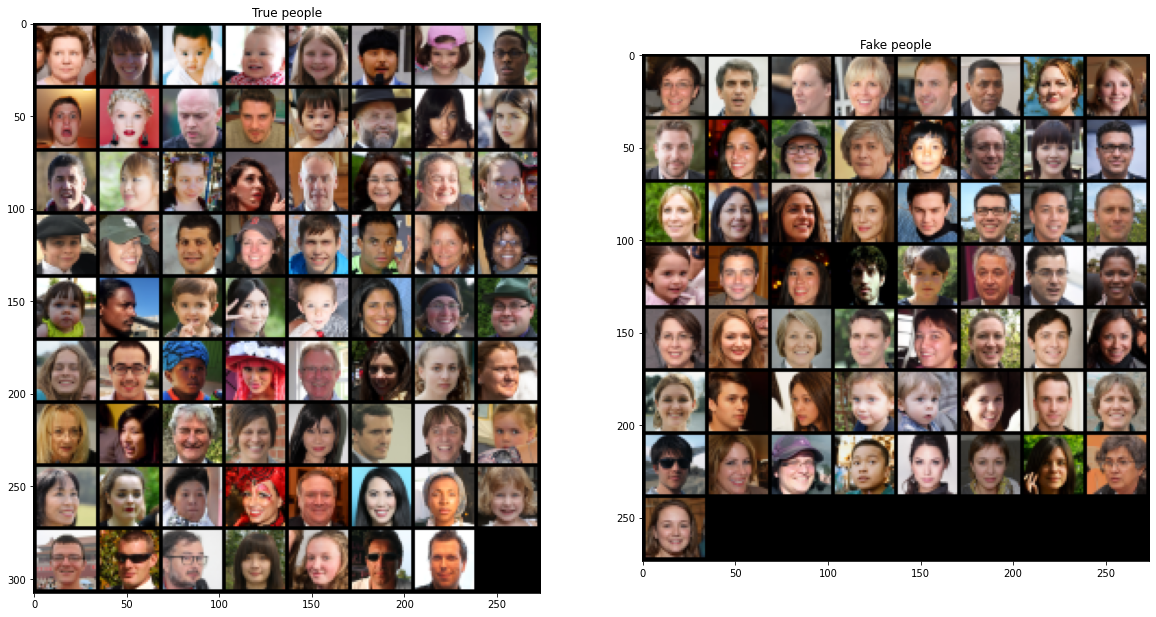

In [ ]:
X_train,y_train,X_valid,y_valid,X_test,y_test=make_datasets(path='../Dataset',size=32)
torch.save(X_train,'X_train.pt')
torch.save(X_valid,'X_valid.pt')
torch.save(X_test,'X_test.pt')
torch.save(y_train,'y_train.pt')
torch.save(y_valid,'y_valid.pt')
torch.save(y_test,'y_test.pt')

- We can observe more details on the true people compared to fake people. Fake people are often represented without accessories, we have sometimes glasses but it is rare. Moreover, there is rarely a fake man with a beard or a moustache and globally fake people have the same face expression. Moreover genuine faces may present complex accessories like special hats and they also may have a complex background behind them on contrary to fake people.

Hence, we clearly see that we can spot easily patterns enable to judge the authenticity of a face. With a bit of chance, ML models should be efficient to detecting them also.





## I - Classic ML Models 


For classical ML models, we are going to transform our images into vectors of dimension 32x32x3, concatening them rows by rows.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score


X_train,y_train,X_valid,y_valid,X_test,y_test=torch.load('X_train.pt'),torch.load('y_train.pt'), \
                                              torch.load('X_valid.pt'),torch.load('y_valid.pt'), \
                                              torch.load('X_test.pt'),torch.load('y_test.pt')

### Dimension Reduction : Fisher or PCA ?

Working with vectors of dimension 32x32x3 is not very useful. It is a large dimension, not very appropriate for the models. Hence, we are tempted to reduce the dimensions of our pictures relevantly using the Fisher projection or the PCA reduction with different dimension. The problem with the Fisher projection is that we can't project our data in a space with a dimension larger than (2-1=) 1 in our case. Hence, the only projection possible with Fisher is a very constraining projection that should result in a good loss of information.

Let's see if this is the case.

#### Fisher 

In [ ]:
fisher_projection = LDA(n_components=1)
fisher_projection.fit(X_train, y_train)

X_train_r=fisher_projection.transform(X_train)

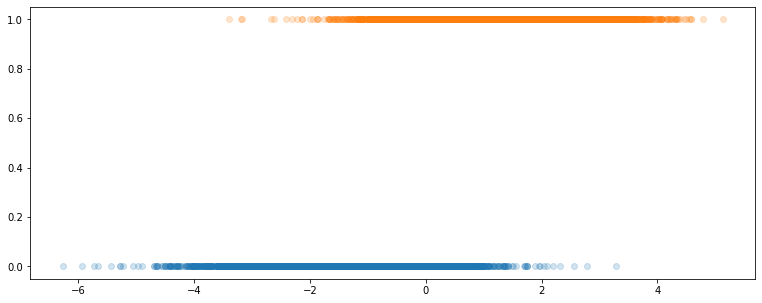

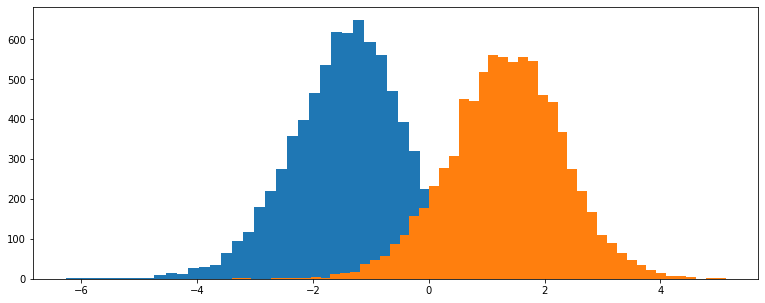

In [ ]:
plt.figure(figsize=(13,5))

plt.scatter(X_train_r[y_train==0],((y_train==0).sum())*[0],alpha=0.2);
plt.scatter(X_train_r[y_train==1],((y_train==1).sum())*[1],alpha=0.2);

plt.figure(figsize=(13,5))

plt.hist(X_train_r[y_train==0],bins=50);
plt.hist(X_train_r[y_train==1],bins=50);

Even if we projected our data in dimension 1, it seems that it is rather easy to find a relevant threshold to separate our classes.
It is not perfect but already surprising that we loose not so many information from this projection.

On top of that, the projections for the two classes seem to follow a normal law, hence, using the LDA, the QDA or the Gaussian Naive Bayes is interesting with this representation.

Let's test what happen when we project our data in dimension 1 with the PCA

#### PCA

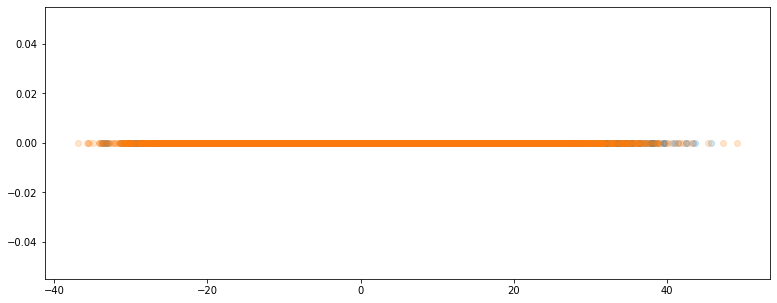

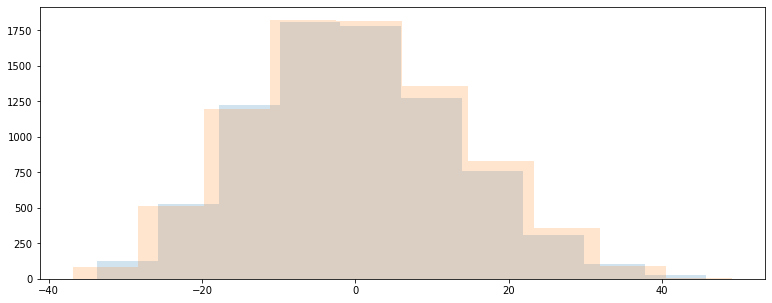

In [ ]:
pca = PCA(n_components=1)
pca.fit(X_train)
X_train_r=pca.transform(X_train)
X_test_r=pca.transform(X_test)

plt.figure(figsize=(13,5))

plt.scatter(X_train_r[y_train==0],len(X_train_r[y_train==0])*[0],alpha=0.2);
plt.scatter(X_train_r[y_train==1],len(X_train_r[y_train==1])*[0],alpha=0.2);

plt.figure(figsize=(13,5))

plt.hist(X_train_r[y_train==0],alpha=0.2);
plt.hist(X_train_r[y_train==1],alpha=0.2);

This time this projection is absolutely not relevant, the classes are indistinguishable ! 
Nevertheless, we can project our data in other dimensions with the PCA unlike the Fisher projection..

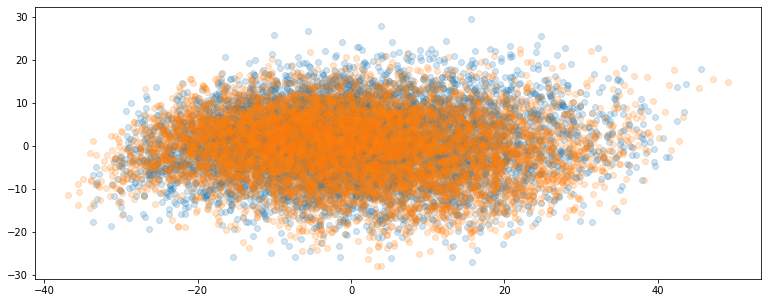

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_r=pca.transform(X_train)
X_test_r=pca.transform(X_test)

plt.figure(figsize=(13,5))

plt.scatter(X_train_r[y_train==0][:,0],X_train_r[y_train==0][:,1],alpha=0.2);
plt.scatter(X_train_r[y_train==1][:,0],X_train_r[y_train==1][:,1],alpha=0.2);

In dimension 2, this is still not relevant.

In the next section we are going to consider the dimension as an hyperparameter ,trying to find the best projection we could done with the PCA for each model and comparing it with the results obtained with the fisher projection.

## Search of best models (dimension and hyperparameters)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics 

def loss_function(y_true,y_pred,cfp=174,cfn=438):
     return cfp*(y_pred.sum())+cfn*(1-y_pred[y_true==1]).sum()

def find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(1,1000)):
  '''

  This function returns the dimension of the space on which it's interesting to project our data with the PCA
  based on the minimum loss observed on the validation set using the dimensions listed in dims.

  '''
  losses=[]
    
  for dim in tqdm(dims):
      pca = PCA(n_components=dim,random_state=0)
      reduced_X=pca.fit_transform(X_train)
      clf.fit(reduced_X,y_train)
      losses.append(loss_function(y_valid,clf.predict(pca.transform(X_valid))))
      
  plt.plot(dims,losses)
  plt.title('Validation Loss according to the dimension')
  plt.xlabel('Dimension')
  plt.ylabel('Loss')
  plt.grid()
        
  print('Best dim found based on the valid set : ',dims[np.argmin(losses)]) 

def performance_summary(y_test,clf=None,X_test=[],y_pred=None):
    '''
      This function returns the perfomances of the given model on the test set
    '''
    
    if (len(X_test)):
      y_pred=clf.predict(X_test)

    print(metrics.classification_report(y_test,y_pred))
    print(f'Potential cost listening our model : {loss_function(y_test,y_pred,cfp=174,cfn=438):,}$')
    print(f'Potential cost suspecting every profile in the test set : {174*len(y_test):,}$')
    print(f'Amount saved with our model compared if we had suspected everyone : {174*len(y_test)-loss_function(y_test,y_pred,cfp=174,cfn=438):,}$')
    print(f'Cost with a perfect prediction : {174*(y_test.sum()).item():,} $')
    print(f'Potential cost suspecting no one in the test set : {438*(y_test.sum()).item():,}$')
    print(f'% inquiries : {np.round((y_pred==1).mean()*100,2)}%')

### LDA

The LDA search for a linear boundary considering that the classes are defined with Gaussians (different expectations, same variance)


Best dim found based on the valid set :  1000


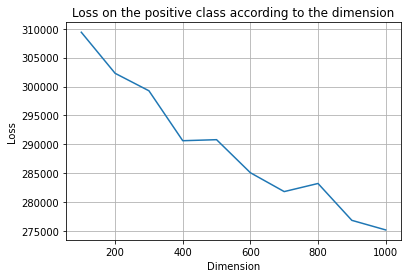

In [ ]:
clf=LDA()
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))

In [ ]:
pca = PCA(n_components=1000,random_state=0)
pca.fit(X_train)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74      1037
         1.0       0.72      0.77      0.74       963

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Potential cost listening our model : 277,422.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 70,578.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 51.4%


This very first model is already satisfying. Indeed, we can clearly observe that listening our model enable to save 70,578.0$ compared to the situation where we suspect everyone. This observation justify on its own the need of a model. Yet, the performances observed are not outstanding but rather reasonable. We see notably that, among people that were fake in our dataset, we succeed in predicting 77% of them, not bad. Moreover, listening our model Facebook employees will have to investigate about half of the members in the test set, a significant gain in time. With our assumptions before, we've saved 50%*2000 = 1000 days of work.

---

Let's compare now the performances of the LDA using the fisher projection this time.

In [ ]:
clf.fit(fisher_projection.transform(X_train),y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1037
         1.0       0.80      0.85      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Potential cost listening our model : 241,086.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 106,914.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.65%


The results obtained with the fisher projection are way more interesting compared to the best PCA projection we got before and yet, it is a projection in dimension 1 !  

- Among people that should have been detected as fake people in our test set, 85% have been well identified. 

- Among all people we suspected to be fake, 80% were really fake. These are rather good performances, and this is surprising to have such performances with this very constraining projection.

Listening our model enable to save 106,914$ compared to the situation where we suspect everyone, much more than before. 

### KNN 

The KNN predicts the class according to the majority class of its k-nearest-neighbors. It is an algorithm which has to compute distances between points in the input space. Hence, the more data and features we have in this input space and the more time it will take to make the prediction. In that case, let's start to find a lower space where we can embed our data and where the knn could be efficient in time, memory and for fulfilling our goal.


Best dim found based on the valid set :  100


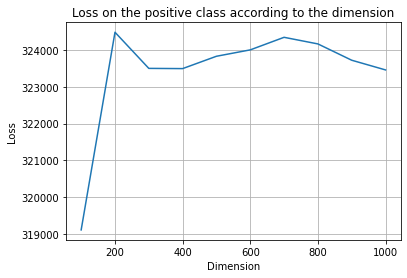

In [ ]:
clf=KNeighborsClassifier(3)
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))


BEST K : 5


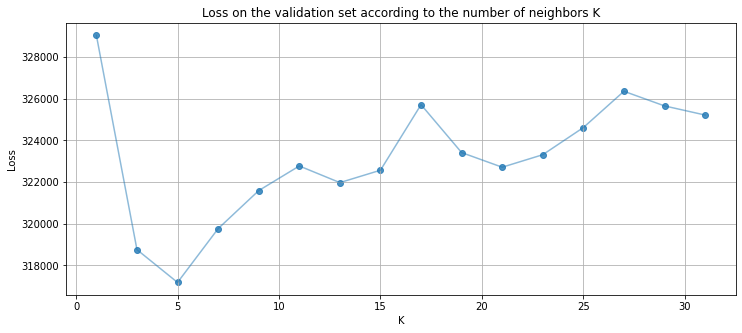

In [ ]:
K=np.arange(1,33,2)

losses=[]

pca = PCA(n_components=100,random_state=0)
pca.fit(X_train)

for k in tqdm(K):
    clf=KNeighborsClassifier(k)
    clf.fit(pca.transform(X_train),y_train)
    losses.append(loss_function(y_valid,clf.predict(pca.transform(X_valid))))
    
print('BEST K :', K[np.argmin(losses)])

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(K,losses,alpha=0.5)
plt.scatter(K,losses,alpha=0.8)
plt.title('Loss on the validation set according to the number of neighbors K')
plt.xlabel('K')
plt.ylabel('Loss');

In [ ]:
clf=KNeighborsClassifier(5)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.74      0.30      0.43      1037
         1.0       0.54      0.89      0.67       963

    accuracy                           0.58      2000
   macro avg       0.64      0.59      0.55      2000
weighted avg       0.64      0.58      0.55      2000

Potential cost listening our model : 322,404.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 25,596.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 78.8%


--- 

**KNN with Fisher**



In [ ]:
clf=KNeighborsClassifier(5)
clf.fit(fisher_projection.transform(X_train),y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82      1037
         1.0       0.80      0.83      0.81       963

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

Potential cost listening our model : 245,916.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 102,084.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.15%


The fisher projection stays more relevant for this model even if, it's a projection in dimension 1.

### Logistic Regression

The Logistic regression search for a linear boundary estimating the probability to belong to the class 1 ("fake") considering the boundary equation.


Best dim found based on the valid set :  1000


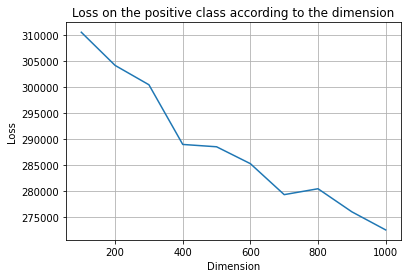

In [ ]:
clf=LogisticRegression(random_state=0)
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))


Best C found : 1.9000000000000001


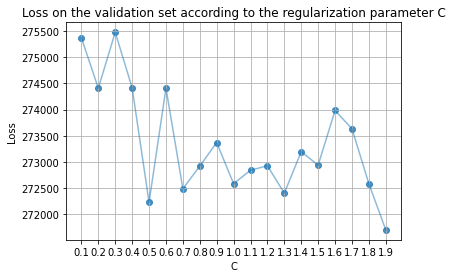

In [ ]:
C=np.arange(0.1,2,0.1)

losses=[]

pca = PCA(n_components=1000,random_state=0)
pca.fit(X_train)


for c in tqdm(C):
    clf=LogisticRegression(C=c,random_state=0)
    clf.fit(pca.transform(X_train),y_train)
    losses.append(loss_function(y_valid,clf.predict(pca.transform(X_valid))))
    
print('Best C found :', C[np.argmin(losses)])
plt.grid()
plt.plot(C,losses,alpha=0.5)
plt.scatter(C,losses,alpha=0.8)
plt.title('Loss on the validation set according to the regularization parameter C')
plt.xticks(C)
plt.xlabel('C')
plt.ylabel('Loss');

In [ ]:
clf=LogisticRegression(C=1.9,random_state=0)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      1037
         1.0       0.72      0.75      0.74       963

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Potential cost listening our model : 279,372.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 68,628.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.45%


---

**LG with Fisher**

In [ ]:
clf.fit(fisher_projection.transform(X_train),y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1037
         1.0       0.80      0.85      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Potential cost listening our model : 241,086.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 106,914.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.65%


### SVM

The SVM is looking for a linear boundary in a space potentially different from the input space and more abstract.




Best dim found based on the valid set :  30


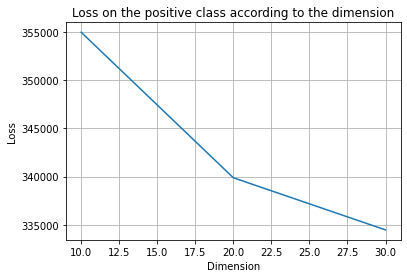

In [ ]:
clf=SVC(kernel='linear',random_state=0)
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(10,40,10))

The SVM with a linear kernel took a lot of time when we worked in high dimensions, hence we decided to not test this model with dimensions larger than 30. 

Unfortunately, this result in a loss on the validation which is much more important than the other models, hence we will not consider this model for further work. However, we propose to also test the other kernels with the SVM to see if we can have good results with a reasonable training time.


Best dim found based on the valid set :  200


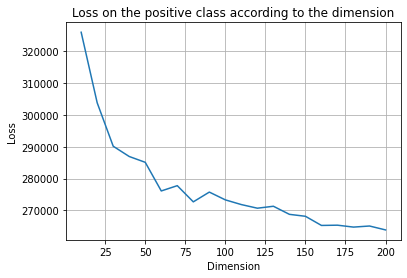

In [ ]:
clf=SVC(kernel='rbf')
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(10,210,10))

In [ ]:
#default gamma
pca = PCA(n_components=200,random_state=0)
pca.fit(X_train)
1 / (200 * pca.transform(X_train).var())

0.0015187684316265758


Best gamma found : 0.003


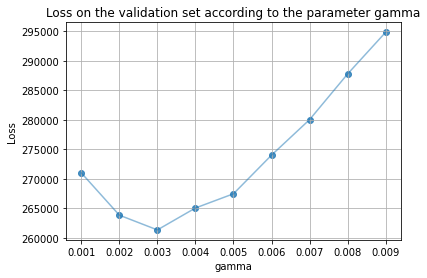

In [ ]:
gammas=np.arange(0.001,0.01,0.001)
losses=[]

pca = PCA(n_components=200,random_state=0)
pca.fit(X_train)

for gamma in tqdm(gammas):
    clf=SVC(kernel='rbf',gamma=gamma)
    clf.fit(pca.transform(X_train),y_train)
    losses.append(loss_function(y_valid,clf.predict(pca.transform(X_valid))))
    
print('Best gamma found :', gammas[np.argmin(losses)])
plt.grid()
plt.plot(gammas,losses,alpha=0.5)
plt.scatter(gammas,losses,alpha=0.8)
plt.title('Loss on the validation set according to the parameter gamma')
plt.xticks(gammas)
plt.xlabel('gamma')
plt.ylabel('Loss');

In [ ]:
clf=SVC(kernel='rbf',gamma=0.003)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      1037
         1.0       0.74      0.76      0.75       963

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000

Potential cost listening our model : 273,000.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 75,000.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 49.5%


The performances of this model are honorable even if, they are not as good as the ones observed before with the LDA for instance.

We are now tempted to use a polynomial kernel to see if it can helps to obtain better results. We can consider for instance a 2-degree polynomial kernel at first for finding the best dimension to project on and then, search for an optimal degree.


Best dim found based on the valid set :  200


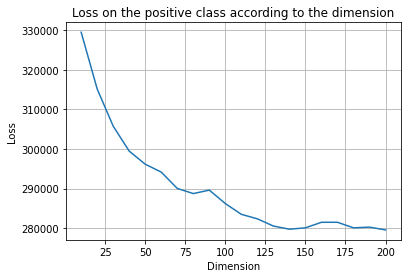

In [ ]:
clf=SVC(kernel='poly',degree=2)
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(10,210,10))


Best degree found : 4


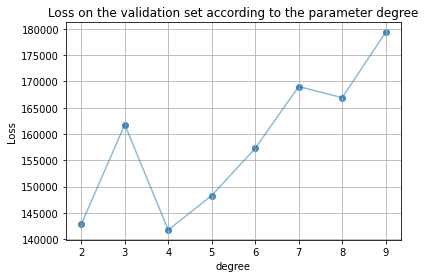

In [ ]:
degrees=np.arange(2,10,1)
losses=[]

pca = PCA(n_components=200)
pca.fit(X_train)

for degree in tqdm(degrees):
    clf=SVC(kernel='poly',degree=degree,random_state=0)
    clf.fit(pca.transform(X_train),y_train)
    losses.append(loss_function(y_valid,clf.predict(pca.transform(X_valid))))
    
print('Best degree found :',degrees[np.argmin(losses)])
plt.grid()
plt.plot(degrees,losses,alpha=0.5)
plt.scatter(degrees,losses,alpha=0.8)
plt.title('Loss on the validation set according to the parameter degree')
plt.xticks(degrees)
plt.xlabel('degree')
plt.ylabel('Loss');

In [ ]:
pca = PCA(n_components=200)
pca.fit(X_train)
clf=SVC(kernel='poly',degree=4)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.81      0.44      0.57      1037
         1.0       0.60      0.89      0.72       963

    accuracy                           0.66      2000
   macro avg       0.71      0.67      0.64      2000
weighted avg       0.71      0.66      0.64      2000

Potential cost listening our model : 295,764.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 52,236.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 71.9%


---

 **SVM with fisher**

Considering the distribution of the points with the fisher projection, the SVM with a non-linear kernel is not very suitable. If we consider the linear kernel, it is suitable but the boundary found will not be very different from the one we found with the LDA and the Logistic regression since these algorithms are also searching for a linear boundary

In [ ]:
clf=SVC(kernel='linear')
clf.fit(fisher_projection.transform(X_train),y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1037
         1.0       0.80      0.84      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Potential cost listening our model : 241,878.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 106,122.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.5%


### Random Forest

The random forest uses different decision trees to make its predictions. Each tree is trained with a random sample of the data at our disposal and, they are trained with a random portion of features available.


Best dim found based on the valid set :  200


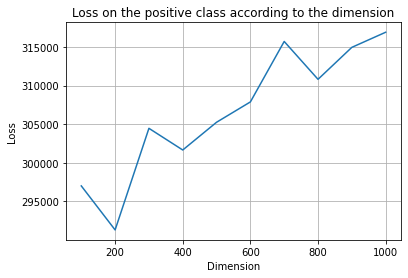

In [ ]:
clf=RandomForestClassifier(random_state=0)
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()

n_estimators = [int(x) for x in np.arange(100,1100,100)]

max_features = ['auto','log2',10,100]

max_depth = [int(x) for x in np.arange(5,20,5)]
max_depth.append(None)

min_samples_split = [10,15,20]

min_samples_leaf = [50,100,500]

max_samples = [0.1, 0.3, 0.5, 0.7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

random_search = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 2,
                               verbose = 2, random_state = 42, n_jobs = -1,scoring='f1') #f1-score

pca = PCA(n_components=200,random_state=0)
pca.fit(X_train)

random_search.fit(pca.transform(X_train), y_train)

print(random_search.best_params_)

import pickle

with open('best_param_random_rf.pickle', 'wb') as f:
    pickle.dump(random_search.best_params_, f)

{'n_estimators': 400, 'min_samples_split': 15, 'min_samples_leaf': 500, 'max_samples': 0.3, 'max_features': 'log2', 'max_depth': None}


In [ ]:
clf = RandomForestClassifier(n_estimators=400,min_samples_split=15,min_samples_leaf=500,max_samples=0.3,max_features='log2',max_depth=None)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67      1037
         1.0       0.65      0.74      0.69       963

    accuracy                           0.68      2000
   macro avg       0.69      0.69      0.68      2000
weighted avg       0.69      0.68      0.68      2000

Potential cost listening our model : 300,294.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 47,706.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 54.7%


### QDA


Best dim found based on the valid set :  400


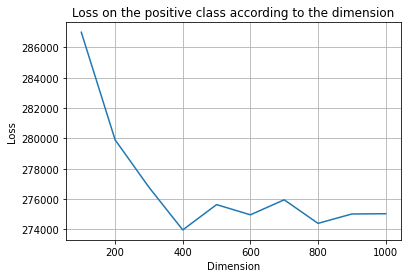

In [ ]:
clf=QDA()
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))

In [ ]:
pca = PCA(n_components=400,random_state=0)
pca.fit(X_train)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      1037
         1.0       0.71      0.77      0.74       963

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Potential cost listening our model : 279,318.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 68,682.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 52.7%


In [ ]:
clf.fit(X_train_r,y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1037
         1.0       0.80      0.84      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Potential cost listening our model : 241,614.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 106,386.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.55%


### Naive Bayes Classifier


Best dim found based on the valid set :  400


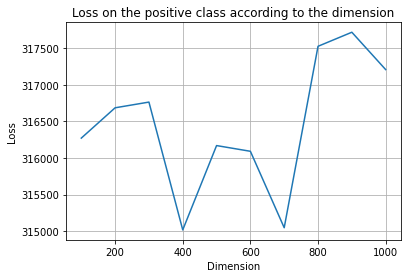

In [ ]:
clf=GNB()
find_best_dimension(clf,X_train,y_train,X_valid,y_valid,dims=np.arange(100,1100,100))

In [ ]:
pca = PCA(n_components=400,random_state=0)
pca.fit(X_train)
clf.fit(pca.transform(X_train),y_train)
performance_summary(clf=clf,X_test=pca.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.60      1037
         1.0       0.59      0.69      0.64       963

    accuracy                           0.62      2000
   macro avg       0.63      0.62      0.62      2000
weighted avg       0.63      0.62      0.62      2000

Potential cost listening our model : 326,184.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 21,816.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 56.35%


In [ ]:
clf.fit(X_train_r,y_train)
performance_summary(clf=clf,X_test=fisher_projection.transform(X_test),y_test=y_test)

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1037
         1.0       0.80      0.84      0.82       963

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

Potential cost listening our model : 241,614.0$
Potential cost suspecting every profile in the test set : 348,000$
Amount saved with our model compared if we had suspected everyone : 106,386.0$
Cost with a perfect prediction : 167,562.0 $
Potential cost suspecting no one in the test set : 421,794.0$
% inquiries : 50.55%


# II - Deep Learning Models

In [ ]:
# Source : https://github.com/Bjarten/early-stopping-pytorch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

X_train,y_train,X_valid,y_valid,X_test,y_test=torch.load('X_train.pt'),torch.load('y_train.pt'), \
                                              torch.load('X_valid.pt'),torch.load('y_valid.pt'), \
                                              torch.load('X_test.pt'),torch.load('y_test.pt')

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

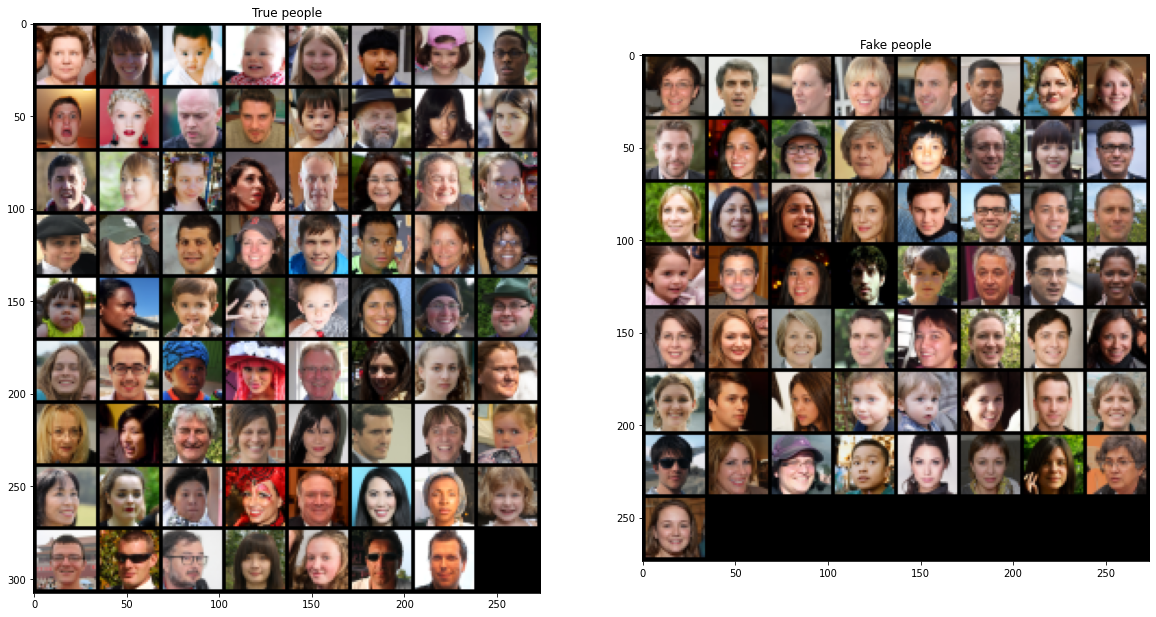

In [ ]:
Xtrain=X_train.view(-1,3,32,32)
Xvalid=X_valid.view(-1,3,32,32)
Xtest=X_test.view(-1,3,32,32)

from torch.utils.data import TensorDataset,DataLoader

train_set=TensorDataset(Xtrain,y_train)
valid_set=TensorDataset(Xvalid,y_valid)
test_set=TensorDataset(Xtest,y_test)

train_loader=DataLoader(train_set,batch_size=128)
valid_loader=DataLoader(valid_set,batch_size=128)
test_loader=DataLoader(test_set,batch_size=128)


plt.figure(figsize=(20,20))
it=iter(train_loader)
real_batch,labels = next(iter(it))

plt.subplot(1,2,1)
# plt.axis("off")
plt.title("True people")
plt.imshow(np.transpose(utils.make_grid(real_batch[labels==0], padding=2, normalize=True).cpu(),(1,2,0)));

plt.subplot(1,2,2)
plt.title("Fake people")
plt.imshow(np.transpose(utils.make_grid(real_batch[labels==1], padding=2, normalize=True).cpu(),(1,2,0)));

## MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self,hiddens=[10,20,30,40,50,60,70,80,90,100]):
        super().__init__()
        self.hiddens=hiddens
        self.modules=[nn.Flatten(),nn.Linear(32*32*3,hiddens[0]),nn.ReLU()]
        
        for i in range(1,len(hiddens)):
          self.modules.append(nn.Linear(hiddens[i-1],hiddens[i]))
          self.modules.append(nn.ReLU())
     
        self.modules.append(nn.Linear(hiddens[-1],1))

        self.out=nn.Sequential(*self.modules)
        
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        out=self.out(x)

        return self.sigmoid(out)

In [ ]:
def return_predictions(loader,model):
    model.to(device)
    predictions=torch.tensor([]).to(device)
    
    model.eval()
    for i,(images,labels) in enumerate(loader):
        images,labels=images.to(device),labels.to(device)
        preds = model(images.float())
        predictions=torch.cat([predictions,preds])
      
    return predictions

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion=nn.BCELoss()

def train(my_model,nb_epochs=100,patience=10):

  my_model.to(device)
  optimizer = torch.optim.Adam(my_model.parameters(),lr=10**(-3)) 

  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=patience,verbose=True)

  train_loss_over_epochs=[]  
  valid_loss_over_epochs=[]  

  for epoch in tqdm(range(nb_epochs)): 

      train_loss=[]

      # Forward pass: Compute predicted y by passing  
      # x to the model 
      my_model.train()
      for images,labels in train_loader:
          images,labels=images.to(device),labels.to(device)
          pred_Y = my_model(images.float())
        
          # Compute loss 
          loss = criterion(pred_Y.view(-1), labels.float()) 
        
          # Zero gradients, perform a backward pass,  
          # and update the weights. 
          optimizer.zero_grad() 
          loss.backward() 
          optimizer.step()
        
          train_loss.append(loss.item())

      train_loss_over_epochs.append(np.mean(train_loss))

      if epoch%100==0:
            print(f"epoch {epoch}, loss {round(loss.item(),4)}")

      my_model.eval()
      valid_losses=[]
      for data, target in valid_loader:
              data,target=images.to(device),labels.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = my_model(data.float())
              # calculate the loss
              loss = criterion(output.view(-1), target.float())
              # record validation loss
              valid_losses.append(loss.item())

      valid_loss=np.mean(valid_losses)
      valid_loss_over_epochs.append(valid_loss)

      early_stopping(valid_loss, my_model)

      if early_stopping.early_stop:
              print("Early stopping")
              # load the last checkpoint with the best model
              my_model.load_state_dict(torch.load('checkpoint.pt'))
              break

  return train_loss_over_epochs,valid_loss_over_epochs

In [ ]:
my_model = MLP(hiddens=[10,20,30]) 
train_loss_over_epochs,valid_loss_over_epochs=train(my_model,nb_epochs=100)
test_predictions=return_predictions(test_loader,my_model).cpu().detach().numpy()
y_pred=(test_predictions>0.5).astype(int)
performance_summary(y_pred=y_pred,y_test=y_test)

epoch 0, loss 0.6411
Validation loss decreased (inf --> 0.637088).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.637088 --> 0.623395).  Saving model ...
Validation loss decreased (0.623395 --> 0.622690).  Saving model ...
EarlyStopping counter: 1 out of 10
Validation loss decreased (0.622690 --> 0.614371).  Saving model ...
Validation loss decreased (0.614371 --> 0.605473).  Saving model ...
Validation loss decreased (0.605473 --> 0.594809).  Saving model ...
Validation loss decreased (0.594809 --> 0.586266).  Saving model ...
Validation loss decreased (0.586266 --> 0.565268).  Saving model ...
Validation loss decreased (0.565268 --> 0.551452).  Saving model ...
Validation loss decreased (0.551452 --> 0.527394).  Saving model ...
Validation loss decreased (0.527394 --> 0.517246).  Saving model ...
Validation loss decreased (0.517246 --> 0.503129).  Saving model ...
Validation loss decreased (0.503129 --> 0.492756).  Saving model ...
Validation loss d

In [ ]:
valid_loss_over_epochs==test_loss_over_epochs

True

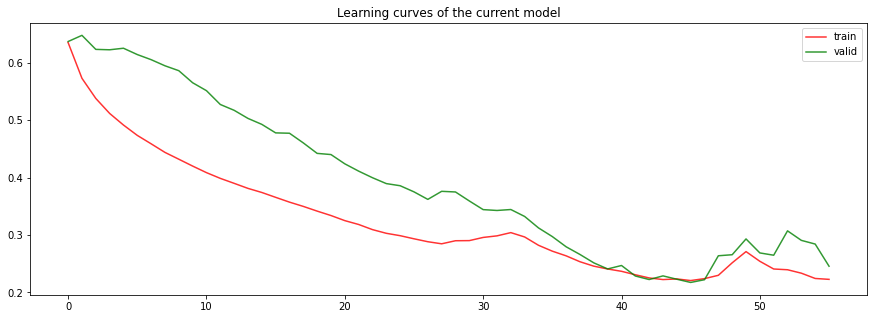

In [ ]:
def plot_learning_curves(train_loss_over_epochs,valid_loss_over_epochs):

  plt.figure(figsize=(15,5))
  plt.plot(train_loss_over_epochs,c='red',alpha=0.8,label='train')
  plt.plot(valid_loss_over_epochs,c='green',alpha=0.8,label='valid')
  plt.legend()
  plt.grid()
  plt.title('Learning curves of the current model');

plot_learning_curves(train_loss_over_epochs,valid_loss_over_epochs)

epoch 0, loss 0.6376
Validation loss decreased (inf --> 0.628816).  Saving model ...
Validation loss decreased (0.628816 --> 0.574489).  Saving model ...
Validation loss decreased (0.574489 --> 0.563653).  Saving model ...
Validation loss decreased (0.563653 --> 0.560065).  Saving model ...
Validation loss decreased (0.560065 --> 0.524489).  Saving model ...
Validation loss decreased (0.524489 --> 0.493972).  Saving model ...
Validation loss decreased (0.493972 --> 0.451806).  Saving model ...
Validation loss decreased (0.451806 --> 0.448644).  Saving model ...
Validation loss decreased (0.448644 --> 0.439466).  Saving model ...
Validation loss decreased (0.439466 --> 0.378186).  Saving model ...
Validation loss decreased (0.378186 --> 0.334931).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.334931 --> 0.272708).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.272708 --> 0.261189).  Saving model ...
Validation loss d

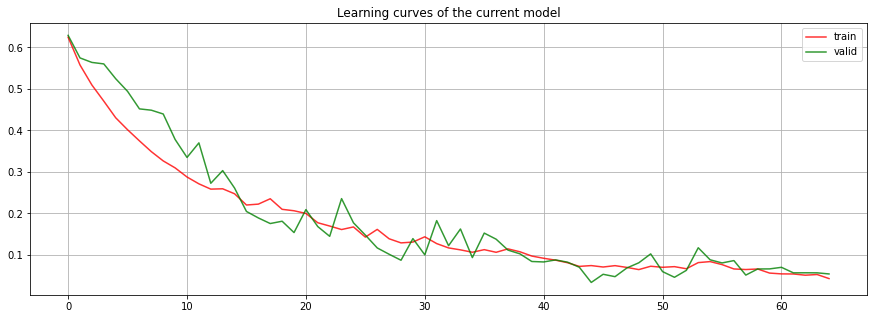

In [ ]:
my_model = MLP(hiddens=[50,100,200,400]) 
train_loss_over_epochs,valid_loss_over_epochs=train(my_model,patience=20,nb_epochs=500)
test_predictions=return_predictions(test_loader,my_model).cpu().detach().numpy()
y_pred=(test_predictions>0.5).astype(int)
performance_summary(y_pred=y_pred,y_test=y_test)
plot_learning_curves(train_loss_over_epochs,valid_loss_over_epochs)

At first, we notice an overfitting (valid loss > train loss). Then, the valid loss seems to oscillate around of the train loss, which is the sign of a safe training.

## CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self,depth=3,out_filters=[8,16,32],kernel_size=3):
        super().__init__()
        self.modules=[nn.Conv2d(3,out_filters[0],kernel_size=kernel_size,stride=1,padding=kernel_size//2),nn.MaxPool2d(kernel_size=kernel_size,stride=2,padding=kernel_size//2),nn.BatchNorm2d(out_filters[0]),nn.ReLU()] #out_filters[0]x16x16
        
        for i in range(1,depth):
          self.modules.append(nn.Conv2d(out_filters[i-1],out_filters[i],kernel_size=kernel_size,stride=1,padding=kernel_size//2)) 
          self.modules.append(nn.MaxPool2d(kernel_size=kernel_size,stride=2,padding=kernel_size//2)) #out_filters[i]*32/(2**(i+1)) * 32/(2**(i+1))
          self.modules.append(nn.BatchNorm2d(out_filters[i]))
          self.modules.append(nn.ReLU())
          
        self.modules.append(nn.Flatten())
        
        self.modules.append(nn.Linear(out_filters[-1]*(32//(2**depth))*(32//(2**depth)),1))

        self.out=nn.Sequential(*self.modules)
        
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        out=self.out(x)

        return self.sigmoid(out)

epoch 0, loss 0.63
Validation loss decreased (inf --> 0.551408).  Saving model ...
Validation loss decreased (0.551408 --> 0.471673).  Saving model ...
Validation loss decreased (0.471673 --> 0.319045).  Saving model ...
Validation loss decreased (0.319045 --> 0.201502).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.201502 --> 0.133333).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.133333 --> 0.041258).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.041258 --> 0.040234).  Saving model ...
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.040234 --> 0.012268).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.012268 --> 0.005278).  Saving model ...
Validation loss decreased (0.005278 --> 0.001223).  Saving model ...
EarlyStopping counter: 1 out of 5
Validation loss decreased (0.001223 --> 0.000492).  Saving

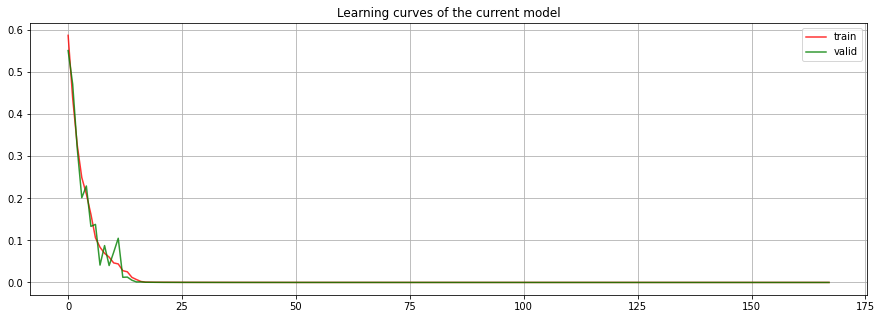

In [ ]:
criterion = torch.nn.BCELoss() 
my_model = CNN(depth=3,out_filters=[64,128,256],kernel_size=3)
train_loss_over_epochs,valid_loss_over_epochs=train(my_model,nb_epochs=500,patience=5)
my_model.load_state_dict(torch.load('checkpoint.pt'))
my_model.eval()
predictions=return_predictions(test_loader,my_model)
y_pred=(predictions>0.5).cpu().detach().numpy().astype(int)
performance_summary(y_pred=y_pred,y_test=y_test)
plot_learning_curves(train_loss_over_epochs,valid_loss_over_epochs)

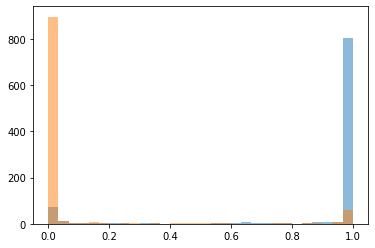

In [ ]:
plt.hist(predictions.cpu().detach().numpy()[y_test==1],alpha=0.5,bins=30);
plt.hist(predictions.cpu().detach().numpy()[y_test==0],alpha=0.5,bins=30);

## Conclusion

| Model | F1-score (class 1) | Cost (\$) | Cost suspecting everyone (\$) |
|---|---|---|---|
| PCA + LDA | 0.74 | 277.422 | 348,000 |
| Fisher + LDA | 0.82 | 241.086 | 348,000 |
| PCA + KNN | 0.67 | 322.404 | 348,000 |
| Fisher + KNN | 0.81 | 245.916 | 348,000 |
| PCA + LR | 0.74 | 279.372 | 348,000 |
| Fisher + LR | 0.82 | 241.086 | 348,000 |
| PCA + SVM(rbf) | 0.75 | 273.000 | 348,000 |
| PCA + SVM(poly) | 0.72 | 295.764 | 348,000 |
| Fisher + SVM(Linear) | 0.82 | 241.878 | 348,000 |
| PCA + RandomForest | 0.69 | 300.294 | 348,000 |
| PCA + QDA | 0.74 | 279.318 | 348,000 |
| Fisher + QDA | 0.84 | 241.614 | 348,000 |
| PCA + Naive Bayes | 0.64 | 326.184 | 348,000 |
| Fisher + Naive Bayes | 0.82 | 241.614 | 348,000 |
| MLP1 | 0.76 | 268,146 | 348,000 |
| MLP2 | 0.74 | 275,472 | 348,000 |
| CNN | 0.89 | 213,840 | 348,000 |

The model which enables to minimize the cost is the CNN

Perspectives to obtain better results :

- Work with higher resolution (64x64 or 128x128)
- Imagine more complex architectures using convolutions or use what is already existing